# Pose Estimation Flow

In [1]:
data_dir = "data/calib"
videos_dir = "data/calib/original"
videos_detected_dir = "data/calib/detected"
csvs_dir = "data/calib/csvs"
matrices_dir = "data/matrices"
experiment_timestamp = "20210526-134439" 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Examine data

In [3]:
def plot_leds_locations(df, keys_dict):
    fleftx = df[keys_dict['FLX']]
    flefty = df[keys_dict['FLY']]
    frightx = df[keys_dict['FRX']]
    frighty = df[keys_dict['FRY']]
    bleftx = df[keys_dict['BLX']]
    blefty = df[keys_dict['BLY']]
    brightx = df[keys_dict['BRX']]
    brighty = df[keys_dict['BRY']]
    time = list(range(len(fleftx)))
    # plot
    plt.figure(figsize=(8,8))
    #plt.gcf().autofmt_xdate()

    plt.plot(time, fleftx, label='fl-x')
    plt.plot(time,flefty, label='fl-y')

    plt.plot(time,frightx, label='fr-x')
    plt.plot(time,frighty, label='fr-y')

    plt.plot(time,bleftx, label='bl-x')
    plt.plot(time,blefty, label='bl-y')

    plt.plot(time,brightx, label='br-x')
    plt.plot(time,brighty, label='br-y')

    plt.legend(loc='upper left')
    plt.show()

from csv import reader
def extract_header(csvs_dir, file):
    in_fle = os.path.join(csvs_dir, file)
    header_lines = []
    with open(in_fle, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        i = 0
        for row in csv_reader:
            i += 1
            if i > 3:
                continue

            header_lines.append(row)
    return header_lines

In [4]:
import numpy as np
from scipy import signal
def apply_filter(x, chunck_maximal_window, window):
    window = min(window, chunck_maximal_window)
    if 'x' in x.name or 'y' in x.name:
        return signal.savgol_filter(x, window, 2)
    return x
    
def filter_chunck(chunck, filter_name, window=21):
    if len(chunck) > 2:
        half_len = int(len(chunck) / 2)
        chunck_maximal_window = half_len if half_len%2==1 else (half_len - 1)
        if filter_name == "savgol":
            chunck = chunck.apply(lambda x: apply_filter(x, chunck_maximal_window, window))
        else:
            chunck = chunck.apply(lambda x: signal.medfilt(x, (window,)) if ('x' in x.name or 'y' in x.name) else x)
    return chunck

In [5]:
def write_df_to_csv(headers, df,csv_file, csvs_dir):
    csv_name = csv_file.split('.')[0]
    print(csv_name)
    with open(f'{csvs_dir}/{csv_name}_filtered.csv', 'w', newline='') as out:
        for row in headers:
            out.write(','.join(row)+'\n')
        filtered_result.to_csv(out, index=False, header=False)

    print('output:',f'{csvs_dir}/{csv_name}_filtered.csv')

In [41]:
import pandas as pd
import os
files = [file for file in os.listdir(csvs_dir) if experiment_timestamp in file and 'filtered' not in file]
files

csv_file = files[3]

In [42]:
df = pd.read_csv(os.path.join(csvs_dir, csv_file), header=2).astype(float)
header_lines = extract_header(csvs_dir, csv_file)

In [43]:
keys = list(df.keys())
keys_dict = {'FLX': keys[1], 'FLY': keys[2], 'FLL': keys[3],
             'FRX': keys[4], 'FRY': keys[5], 'FRL': keys[6],
             'BLX': keys[7], 'BLY': keys[8], 'BLL': keys[9],
             'BRX': keys[10], 'BRY': keys[11], 'BRL': keys[12]}

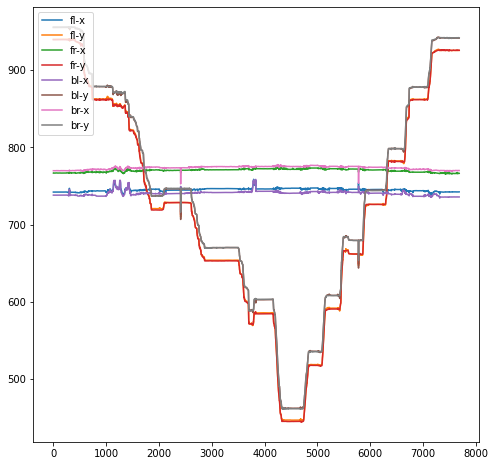

In [44]:
plot_leds_locations(df, keys_dict)

In [45]:
likelihood = 0.95
led_missing_chuncks = df.loc[(df[keys_dict['FLL']] < likelihood) | (df[keys_dict['FRL']] < likelihood)
           | (df[keys_dict['BLL']] < likelihood) | (df[keys_dict['BRL']] < likelihood)]
led_missing_chuncks_index = led_missing_chuncks.index

In [46]:
filter_name="savgol"
frames = []
last = -1
for i in range(len(led_missing_chuncks)):
    if led_missing_chuncks_index[i] - last > 1:
        chunck = df[last + 1:led_missing_chuncks_index[i]-1]
        chunck = filter_chunck(chunck, filter_name,window=11)
        frames.append(chunck)
    last = led_missing_chuncks_index[i]
                              
chunck = df[last+1:]
chunck = filter_chunck(chunck, filter_name,window=11)
frames.append(chunck)  


only_likely_filtered_result =  pd.concat(frames)   
only_likely_filtered_result = only_likely_filtered_result.sort_index()

led_missing_chuncks =  pd.DataFrame(led_missing_chuncks, index=led_missing_chuncks_index)
frames.append(led_missing_chuncks)                            
filtered_result = pd.concat(frames)
filtered_result = filtered_result.sort_index()

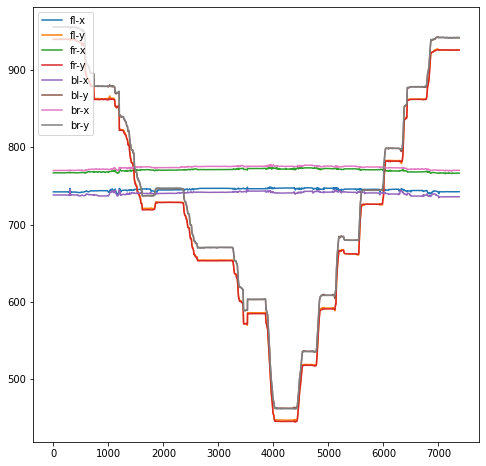

In [47]:
plot_leds_locations(only_likely_filtered_result, keys_dict)

In [48]:
write_df_to_csv(header_lines, filtered_result, csv_file, csvs_dir)

calib_width_top_20210526-134439DLC_resnet50_calib_only_topJul9shuffle1_37000
output: data/calib/csvs/calib_width_top_20210526-134439DLC_resnet50_calib_only_topJul9shuffle1_37000_filtered.csv


### Camera Matrices Calculation

In [ ]:
%run calculate_cameras_matrices -h

Notice: this would open a window with the first frame of the video. Please select the asked points with a rightclick.

In [ ]:
%run calculate_cameras_matrices -d {videos_dir} -t {experiment_timestamp}  -m {matrices_dir}

In [46]:
%run pixels_locations_to_arena_coordinates -h

usage: pixels_locations_to_arena_coordinates.py [-h] [-o OUTPUT] [--csv CSV] [-m MATRICES_DIR] [-t TIMESTAMP]
                                                [-l LIKELIHOOD] [-f FILTER] [-v VIDEOS_DIR]

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        directory of the output
  --csv CSV
  -m MATRICES_DIR, --matrices_dir MATRICES_DIR
                        directory of the input matrices
  -t TIMESTAMP, --timestamp TIMESTAMP
                        the timestamp of the experiment
  -l LIKELIHOOD, --likelihood LIKELIHOOD
                        the minimum likelihood of points to use
  -f FILTER, --filter FILTER
                        file name filter
  -v VIDEOS_DIR, --videos_dir VIDEOS_DIR
                        the videos dir if you want to visualize result


In [ ]:
%run pixels_locations_to_arena_coordinates -v {videos_dir} -o {videos_detected_dir} --csv {csvs_dir} -t 134439 -f filtered -l 0.95 -m {matrices_dir}

read experiments csvs: ['calib_width_back_20210526-134439DLC_resnet50_calib_only_backJul7shuffle1_43000_filtered.csv', 'calib_width_left_20210526-134439DLC_resnet50_calib_only_leftJul8shuffle1_44500_filtered.csv', 'calib_width_right_20210526-134439DLC_resnet50_calib_only_rightJul8shuffle1_50500_filtered.csv', 'calib_width_top_20210526-134439DLC_resnet50_calib_only_topJul9shuffle1_37000_filtered.csv']
visualizing analysis with video: calib_width_back_20210526-134439.mp4
writing analysis video: data/calib/detected/134439_back_detected.mp4
analyzing camera: Camera.BACK


In [ ]:
%run pixels_locations_to_arena_coordinates -v {videos_dir} -o {videos_detected_dir} --csv {csvs_dir} -t {experiment_timestamp} -m {matrices_dir}

In [6]:
data_dir = "data/animal"
videos_dir = "data/animal/original"
videos_detected_dir = "data/animal/detected"
csvs_dir = "data/animal/csvs"

experiment_timestamp = "20210221T140130" 

In [ ]:
%run pixels_locations_to_arena_coordinates -v {videos_dir} -o {videos_detected_dir} --csv {csvs_dir} -t {experiment_timestamp} -m {matrices_dir}

### Show results videos

In [9]:
video_name = "calib_long_back_20210526-132415.mp4"
detected_video_name = "back_20210526-132415_back_detected_likelihood.9.mp4"

In [12]:
from IPython.display import HTML
from os import path
video_path=path.join(videos_dir, video_name)
detected_video_path=path.join(videos_detected_dir, detected_video_name)
HTML(f"""
<video width=450 controls>
      <source src="{video_path}" type="video/mp4">
</video>
<video width=450 controls>
      <source src="{detected_video_path}" type="video/mp4">
</video>
""")

In [ ]:
import pandas as pd
csv_path = r'data/calib/detected\points\134439_points_073020211405.csv'
df = pd.read_csv(csv_path)
df

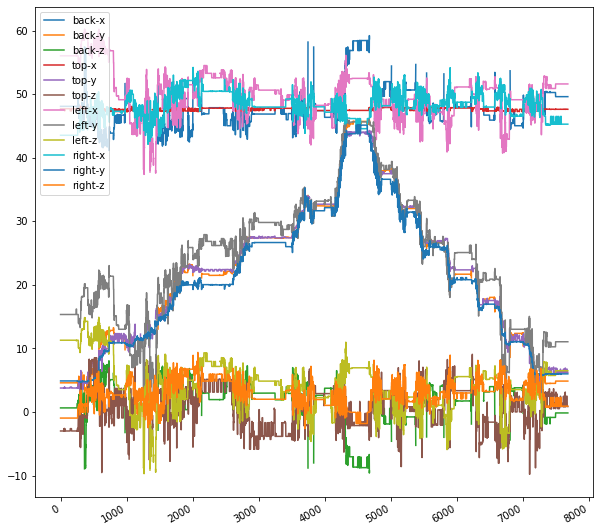

In [10]:
x = df['backcenterx']
y = df['backcentery']
z = df['backcenterz']
topx = df['topcenterx']
topy = df['topcentery']
topz = df['topcenterz']
leftx = df['leftcenterx']
lefty = df['leftcentery']
leftz = df['leftcenterz']
rightx = df['rightcenterx']
righty = df['rightcentery']
rightz = df['rightcenterz']
time = list(range(len(x)))
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))
plt.plot(time,x, label='back-x')
plt.plot(time,y, label='back-y')
plt.plot(time,z, label='back-z')

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')

plt.plot(time,leftx, label='left-x')
plt.plot(time,lefty, label='left-y')
plt.plot(time,leftz, label='left-z')

plt.plot(time,rightx, label='right-x')
plt.plot(time,righty, label='right-y')
plt.plot(time,rightz, label='right-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()

In [15]:
from scipy.signal import savgol_filter
fieldnames = ["backcenterx", "backcentery","topcenterz", "topcenterx", "topcentery","topcenterz",
             "leftcenterx", "leftcentery","leftcenterz", "rightcenterx", "rightcentery","rightcenterz"]
df = df.apply(lambda x: savgol_filter(x,61,1) if x.name in fieldnames else x)

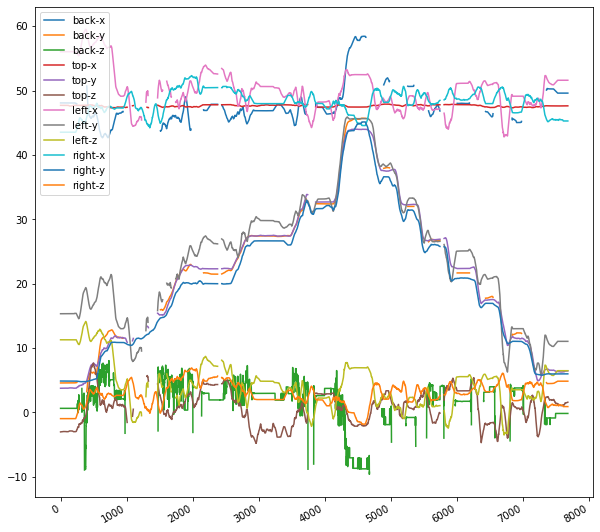

In [16]:
x = df['backcenterx']
y = df['backcentery']
z = df['backcenterz']
topx = df['topcenterx']
topy = df['topcentery']
topz = df['topcenterz']
leftx = df['leftcenterx']
lefty = df['leftcentery']
leftz = df['leftcenterz']
rightx = df['rightcenterx']
righty = df['rightcentery']
rightz = df['rightcenterz']
time = list(range(len(x)))
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))
plt.plot(time,x, label='back-x')
plt.plot(time,y, label='back-y')
plt.plot(time,z, label='back-z')

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')

plt.plot(time,leftx, label='left-x')
plt.plot(time,lefty, label='left-y')
plt.plot(time,leftz, label='left-z')

plt.plot(time,rightx, label='right-x')
plt.plot(time,righty, label='right-y')
plt.plot(time,rightz, label='right-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()

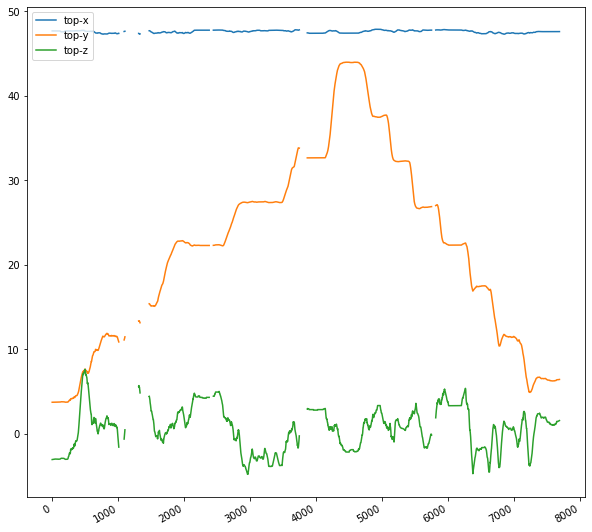

In [17]:
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()